In [100]:
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import sklearn.metrics as sk_metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
import tempfile
import statsmodels.api as sm
import os
from tensorflow import keras
import statsmodels.formula.api as smf

from tensorflow.keras import layers
from sklearn.feature_selection import SelectKBest
from sklearn import metrics
import pymssql
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from tqdm import tqdm
import numpy as np
from tensorflow.python.ops.numpy_ops import np_config
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from xgboost import plot_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
import warnings
from sklearn.pipeline import make_pipeline
from mpl_toolkits import mplot3d
import yaml
from scipy.stats import pearsonr
import decimal
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
from collections import defaultdict
from datetime import datetime
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from matplotlib import pyplot
import pickle

np_config.enable_numpy_behavior()
random_state = 2023

# Preset matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

print(tf.__version__)
# To make the results reproducible, set the random seed value.
tf.random.set_seed(22)

2.9.0


In [101]:
import decimal
import math
import pickle
from collections import defaultdict
from datetime import datetime
import yaml
from matplotlib import pyplot
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
import pymssql as pss
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt


class DatabaseLoader:
    def __init__(self, _server_info):
        _conn = pss.connect(server=_server_info['name'], user=_server_info['user'],
                                password=_server_info['password'], database=_server_info['database'])

        self._cursor = _conn.cursor()
        self._empty = True
        self.df = None
        self._global_primary = None
        self._global_secondary = None
        self._global_primary_type = None
        self._global_secondary_type = None
        self._target = None
        self._special_target = None
        self._model = None

    def get_column_index(self, _column_name):
        for index, col in enumerate(self._cursor.description):
            if col[0] == _column_name:
                return index

    def replace_col_name(self, _cur_headers, _old, _new):
        for idx, header in enumerate(_cur_headers):
            if header == _old:
                _cur_headers[idx] = _new

    def load_tables(self, _tables, _ignore=None):
        for _table in _tables:
            self.load_table(_table, ignore=_ignore)

    def load_table(self, _table_info, ignore=None):
        if ignore is None:
            ignore = []
        self._cursor.execute("SELECT * FROM {table}".format(table=_table_info['name']))

        _headers = []
        _rows = []

        for entity in self._cursor.description:
            _headers.append(entity[0])

        _primary_index = self.get_column_index(_table_info['primary'])
        _secondary_index = self.get_column_index(_table_info['secondary'])

        _res = self._cursor.fetchone()
        while _res:
            _row = [element for element in _res]
            if _row[_primary_index] is not None and _row[_primary_index].strip() != "n/a" and _row[_secondary_index] != _table_info['null_secondary']:
                # Strips trailing whitespace from strings
                for _idx, item in enumerate(_row):
                    if isinstance(item, str):
                        _row[_idx] = item.strip()

                    if isinstance(item, decimal.Decimal):
                        _row[_idx] = float(item)

                _rows.append(_row)
            _res = self._cursor.fetchone()

        if self._empty:
            self._empty = False
            self.df = pd.DataFrame(_rows, columns=_headers)
            self._global_primary = _table_info['primary']
            self._global_secondary = _table_info['secondary']
            self._global_primary_type = type(self.df[self._global_primary].iloc[0])
            self._global_secondary_type = type(self.df[self._global_secondary].iloc[0])
        else:
            # Replace the primary and secondary key column names with the global primary and secondary key names
            self.replace_col_name(_headers, _table_info['primary'], self._global_primary)
            self.replace_col_name(_headers, _table_info['secondary'], self._global_secondary)

            temp_df = pd.DataFrame(_rows, columns=_headers)
            # Cast the primary and secondary keys to global type
            temp_df[self._global_primary] = temp_df[self._global_primary].astype(self._global_primary_type)
            temp_df[self._global_secondary] = temp_df[self._global_secondary].astype(self._global_secondary_type)

            self.df = pd.merge(temp_df, self.df, how='inner', on=['VIN', 'CreaditScore'])

        # Remove any columns to ignore
        self.df = self.df.drop(labels=ignore, axis=1, errors='ignore')

    def dropna(self):
        # Drop any rows with NaN values
        self.df.dropna(how='any', inplace=True)

    def move_col_to_end(self, col):
        _cols = list(self.df.columns)
        _cols.remove(col)
        _cols.append(col)
        self.df = self.df[_cols]

    def prune_for_target(self, _prediction_info):
        self._target = _prediction_info['target']
        _replace_guide = _prediction_info['replace']

        self.df = self.df[self.df[self._target].isin(list(_replace_guide.keys()))]
        for key, value in _replace_guide.items():
            self.df[self._target].replace(to_replace=key, value=value, inplace=True)

        # Move the target to the end of the dataframe
        _cols = list(self.df.columns)
        _cols.remove(self._target)
        _cols.append(self._target)
        self.df = self.df[_cols]

        if _prediction_info['doSpecial']:
            if _prediction_info['special'] == 'DelqPct':
                self.df = self.df[self.df['OpeningBalance'] != 0]
                self.df['DelqPct'] = self.df.apply(lambda _row: (100 * _row['Delq']) / _row['OpeningBalance'], axis=1)

                # Remove the old target and Delq from the dataframe
                _cols = list(self.df.columns)
                _cols.remove(self._target)
                _cols.remove("Delq")
                self.df = self.df[_cols]
                self._target = "DelqPct"
            elif _prediction_info['special'] == 'ProfitLoss':
                self.df['PaidForLoan'] = self.df.apply(
                    lambda _row: _row['OpeningBalance'] - (_row['OpeningBalance'] * .15), axis=1)
                self.df['PL'] = self.df.apply(lambda _row: _row['NumberPmnt'] * _row['Payment'] - _row['PaidForLoan'],
                                              axis=1)

    def remove_majority_null(self, threshold=.1):
        total = len(self.df)
        cols_to_drop = []
        percents = []
        for column in self.df.columns:
            non_null_count = 0
            for _idx, item in self.df[column].items():
                #TODO redo
                if item is None or (not isinstance(item, str) and math.isnan(item)):
                    None
                else:
                    non_null_count += 1
            percent = float(non_null_count) / float(total)

            if percent < (1-threshold):
                cols_to_drop.append(column)
                percents.append((1 - percent) * 100)

        self.df = self.df.drop(cols_to_drop, axis=1)
        for _idx, column in enumerate(cols_to_drop):
            print(
                "Dropping {column} since {percent}% of entires were Null".format(column=column, percent=percents[_idx]))

    def contains_null_or_is_categorical(self, series):
        if self.is_categorical(series):
            return True

        for _idx, item in series.items():
            if item is None:
                return True

        return False

    @staticmethod
    def get_type_series(series):
        for _idx, item in series.items():
            if item is not None:
                return type(item)
        return None

    def is_categorical(self, series):
        return self.get_type_series(series) == str

    def get_correlated_entities(self, threshold=0.1, inplace=False):
        corrs = dict()
        print("Computing Entity Correlations")
        for col in tqdm(self.df.columns):
            if col == self._target or self.contains_null_or_is_categorical(self.df[col]):
                continue
            corr, _ = pearsonr(self.df[col], self.df[self._target])
            corrs[col] = abs(corr)

        corrs = {_k: _v for _k, _v in sorted(corrs.items(), key=lambda item: item[1])}

        goodCols = []

        for col, score in corrs.items():
            if score >= threshold:
                goodCols.append(col)

        print(goodCols)

        if inplace:
            goodCols.append(self._target)
            self.df = self.df[goodCols]
        else:
            return self.df[goodCols]

    def remove_outliers(self, lower_thresh=0.00, upper_thresh=0.999, ignore=None):
        if ignore is None:
            ignore = []
        for col in self.df.columns:
            if col in ignore or col == self._target or self.is_categorical(self.df[col]):
                continue
            percentiles = self.df[col].quantile([lower_thresh, upper_thresh]).values
            self.df.loc[self.df[col] <= percentiles[0], col] = percentiles[0]
            self.df.loc[self.df[col] >= percentiles[1], col] = percentiles[1]

    def get_target_col(self):
        return self.df[self._target]

    def get_categorical_vars(self):
        cats = []
        for col in self.df.columns:
            if self.is_categorical(self.df[col]):
                cats.append(col)
        return cats

    def one_hot(self, inplace=False):
        cat_attribs = self.get_categorical_vars()
        full_pipeline = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), cat_attribs)],
                                          remainder='passthrough')
        encoder = full_pipeline.fit(self.df)
        if inplace:
            self.df = encoder.transform(self.df)
        else:
            return encoder.transform(self.df)

    def one_hot_dummies(self, inplace=False):
        cat_attribs = self.get_categorical_vars()
        temp_df = self.df.copy(deep=True)
        print("One Hot Encoding")
        for cat in tqdm(cat_attribs):
            one_hot = pd.get_dummies(self.df[cat])
            for i in one_hot.columns:
                new_name = cat + i
                new_name = new_name.replace("[", "")
                new_name = new_name.replace("]", "")
                new_name = new_name.replace("<", "")
                one_hot.rename(columns={i: new_name}, inplace=True)
            temp_df = temp_df.drop(cat, axis=1)
            temp_df = pd.concat([temp_df, one_hot], axis=1)

        if inplace:
            self.df = temp_df
            self.move_col_to_end(self._target)
        else:
            return temp_df

    def get_df_no_categoricals(self):
        return self.df.drop(self.get_categorical_vars(), axis=1)

    def get_df_highest_category(self, category, only_quantitative=True):
        counts = defaultdict(int)

        for item in self.df[category]:
            counts[item] += 1

        counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}

        highest = list(counts.keys())[0]
        print("Training on {item}".format(item=highest))

        if only_quantitative:
            return self.df[self.df[category] == highest].drop(self.get_categorical_vars(), axis=1)
        else:
            return self.df[self.df[category] == highest]

    def standardize_categorical_column(self, col, inplace=False):
        if inplace:
            self.df[col] = self.df[col].apply(
                lambda x: x.replace("0", "").replace("1", "").replace("2", "").replace("3", "").replace("4",
                                                                                                        "").replace("5",
                                                                                                                    "").replace(
                    "6", "").replace("7", "").replace("8", "").replace("8", "").replace(" ", ""))
        else:
            return self.df[col].apply(
                lambda x: x.replace("0", "").replace("1", "").replace("2", "").replace("3", "").replace("4",
                                                                                                        "").replace("5",
                                                                                                                    "").replace(
                    "6", "").replace("7", "").replace("8", "").replace("8", "").replace(" ", ""))

    def print_cols(self):
        for col in self.df.columns:
            print(col)

    def print_model_stats(self, y_test, preds):
        # print("Preds")
        # print(preds[:10])
        # print("Actual")
        # print(y_test[:10])
        print("Confusion Matrix: ")
        print(confusion_matrix(y_test, preds))
        print("Accuracy: ")
        print(accuracy_score(y_test, preds))
        print("F1: ")
        print(f1_score(y_test, preds))

    @staticmethod
    def print_feature_importance(_model):
        _importance = _model.feature_importances_
        # summarize feature importance
        print("Feature Importance: ")
        for i, v in enumerate(_importance):
            print('Feature: %0d, Score: %.5f' % (i, v))
        # plot feature importance
        pyplot.bar([x for x in range(len(_importance))], _importance)
        pyplot.show()

    @staticmethod
    def get_model_name(_model, y_test, preds, model_name=""):
        _acc = accuracy_score(y_test, preds)
        cur = datetime.now().strftime("%D:%H:%M").replace("/", "-").replace(":", "_", 1).replace(":", "-")

        return "{model_name}_{cur}-{acc}%.pkl".format(model_name=model_name, cur=cur, acc=round(_acc, 3))

    def train_model(self, _model, use_categoricals=False, print_stats=False, print_feature_importance=False, save=False,
                    save_dir="../Models/", model_name="model.pkl"):
        data = None
        if use_categoricals:
            data = self.df.copy(deep=True)
        else:
            data = self.get_df_no_categoricals().copy(deep=True)

        xtrain, xtest, ytrain, ytest = train_test_split(data.iloc[:, :-1], data.iloc[:, -1:], test_size=0.2)

        _model.fit(xtrain, ytrain)
        self._model = _model

        preds = _model.predict(xtest)

        if print_stats:
            self.print_model_stats(ytest, preds)

        if print_feature_importance:
            self.print_feature_importance(_model)

        if save:
            # filename = self.get_model_name(model, y_test, preds, model_name=model_name)
            filename = model_name
            print("Saving: {filename}".format(filename=filename))
            pickle.dump(_model, open(filename, 'wb+'))

            # Save a model config file
            conf = dict()
            trained_entities = list(xtrain.columns)
            conf['entities'] = trained_entities

            with open("model_config.yaml", 'w+') as yamlfile:
                yaml.dump(conf, yamlfile)
                print("Model config write successful")

    def run_model(self, model_name="model.pkl", use_categoricals=False):
        _model = pickle.load(open(model_name, 'rb'))
        with open("model_config.yaml") as f:
            model_config = yaml.load(f, Loader=yaml.FullLoader)

        self._model = _model

        input_data = None
        if use_categoricals:
            input_data = self.df.copy(deep=True)
        else:
            input_data = self.get_df_no_categoricals().copy(deep=True)

        # Drop all entities not used during training
        input_data = input_data[model_config['entities']]

        # drop all rows containing na
        input_data.dropna(how='any', inplace=True)

        input_data["Prediction"] = _model.predict(input_data)

        return input_data

    def get_scores(self, use_categoricals=False, plot = False):
        # summarize feature importance
        # importance = self._model.feature_importances_

        df = self.df
        if not use_categoricals:
            df = self.get_df_no_categoricals()

        importances = list(zip(self._model.feature_importances_, df.columns))
        importances.sort(reverse=True)

        scores = dict()
        for score, entity in importances:
            scores[entity] = score

        mag = sum(scores.values())

        for entity in list(scores.keys()):
            scores[entity] = scores[entity]/mag * 100

        names = list(scores.keys())
        values = list(scores.values())

        if plot:
            plt.bar(range(len(scores)), values, tick_label=names)
            plt.xticks(rotation=45, ha='right')
            plt.show()

        for entity, score in scores.items():
            print("{entity}: {score}".format(entity=entity, score=score))

In [102]:
with open("config.yaml") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
server_info = config["server"]

dbl = DatabaseLoader(server_info)

dbl.load_tables(config['tables'], config['ignore'])
dbl.prune_for_target(config['predictions'])
dbl.remove_majority_null(threshold=.1) #removes columns where a majority of entries are null
dbl.dropna() #removes all rows that have NA values. Do this after remove_majority_null
dbl.remove_outliers(ignore = config['outliers']['ignore'])

# dbl.one_hot_dummies(True)

Dropping Discount since 100.0% of entires were Null
Dropping CustomScore since 95.77425632471504% of entires were Null
Dropping VehicleType since 11.954406449819299% of entires were Null
Dropping RentMortgage since 99.88879621907145% of entires were Null
Dropping CashDown since 99.88879621907145% of entires were Null
Dropping MonthsAtHome since 99.88879621907145% of entires were Null
Dropping AvailableIncomePercent since 99.88879621907145% of entires were Null
Dropping HomeOwner since 99.88879621907145% of entires were Null
Dropping PaidAccounts since 99.94439810953573% of entires were Null
Dropping HasMortgage since 100.0% of entires were Null
Dropping InquiriesLast6Months since 99.94439810953573% of entires were Null
Dropping OpenAcctsInGoodStatus since 99.94439810953573% of entires were Null
Dropping OpenTotalInBadStatus since 99.94439810953573% of entires were Null


In [103]:
from sklearn.ensemble import RandomForestClassifier

# model = RandomForestClassifier(n_estimators = 1000)
model = RandomForestClassifier(n_estimators = 1000)
dbl.train_model(model, print_stats = True, save = True)

/var/folders/kh/np0tdw052gg77h97rt6rm3l80000gn/T/ipykernel_43003/2187759472.py:337: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  _model.fit(xtrain, ytrain)


Confusion Matrix: 
[[234 140]
 [109 212]]
Accuracy: 
0.641726618705036
F1: 
0.6300148588410105
Saving: model.pkl
Model config write successful


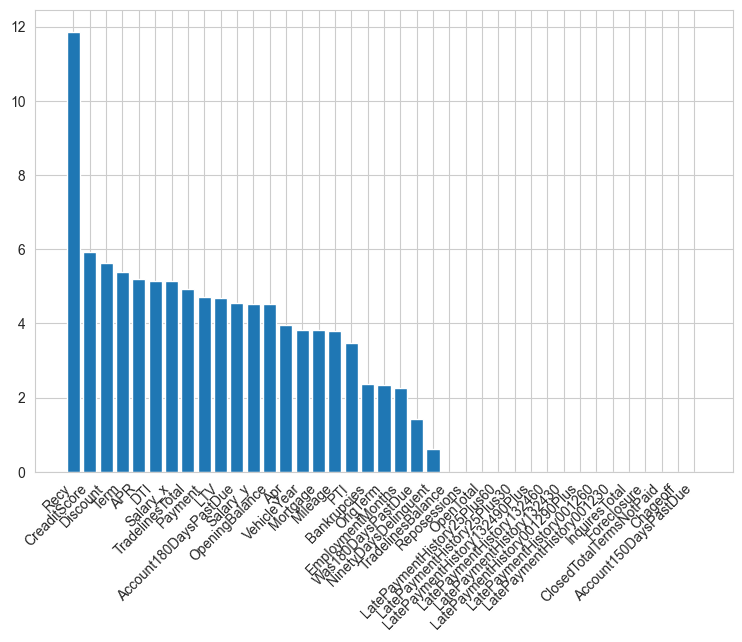

Recy: 11.862826058876873
CreaditScore: 5.911736744828087
Discount: 5.620060686539017
Term: 5.37303308635188
APR: 5.198039596847606
DTI: 5.1375945271239125
Salary_x: 5.134794580212751
TradelinesTotal: 4.937326892635503
Payment: 4.715995092104212
LTV: 4.673031375580088
Account180DaysPastDue: 4.561944360426906
Salary_y: 4.522042855041837
OpeningBalance: 4.520275797187887
Apr: 3.951765000596271
VehicleYear: 3.8215012267964337
Mortgage: 3.8199568370052575
Mileage: 3.795403951185619
PTI: 3.4769239118935555
Bankrupcies: 2.3608944655811053
OrigTerm: 2.3340714191891916
EmploymentMonths: 2.25900065948731
Was180DaysPastDue: 1.41148440112255
NinetyDaysDelinquent: 0.6002964733861519
TradelinesBalance: 0.0
Reposessions: 0.0
OpenTotal: 0.0
LatePaymentHistory25Plus60: 0.0
LatePaymentHistory25Plus30: 0.0
LatePaymentHistory132490Plus: 0.0
LatePaymentHistory132460: 0.0
LatePaymentHistory132430: 0.0
LatePaymentHistory001290Plus: 0.0
LatePaymentHistory001260: 0.0
LatePaymentHistory001230: 0.0
InquiresTotal

In [104]:
# Now pretend we load data with no labels (i.e. customers that we want to predict)
testdbl = DatabaseLoader(server_info)
# We still need to load all the tables that contain the entities
testdbl.load_tables(config['tables'], config['ignore'])
# We do not need to call prune for target (since the target should not exist in the database)

# Now, we can run the model, which will append a prediction to customer
testdf = testdbl.run_model("model.pkl")

# We can also get the entity scores from the model
testdbl.get_scores(plot=True)